# Tutorial: Train a Regression model with Automated Machine Learning

## Prerequisites
  
* Create a workspace and its configuration file (**config.json**)  
* Upload your **config.json** to the same folder as this notebook

### Start a notebook

To follow along, start a new notebook from the same directory as **config.json** and copy the code from the sections below.


## Set up your development environment

All the setup for your development work can be accomplished in the Python notebook.  Setup includes:

* Import Python packages
* Configure a workspace to enable communication between your local computer and remote resources
* Create a directory to store training scripts

### Import packages
Import Python packages you need in this tutorial.

In [1]:
import azureml.core
import pandas as pd
from azureml.core.workspace import Workspace
from azureml.train.automl.run import AutoMLRun
import time
import logging
from sklearn import datasets
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import random
import numpy as np

### Configure workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **aml_config/config.json** and loads the details into an object named `ws`.  `ws` is used throughout the rest of the code in this tutorial.

Once you have a workspace object, specify a name for the experiment and create and register a local directory with the workspace. The history of all runs is recorded under the specified experiment.

In [2]:
ws = Workspace.from_config()
# choose a name for the run history container in the workspace
experiment_name = 'automl-classifier_for_airfair6'
# project folder
project_folder = './automl-classifier_for_airfair6'

import os

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data=output, index=['']).T

Found the config file in: C:\Users\usseer1\Desktop\MachineLearningNotebooks-master\tutorials\config.json


,
SDK version,0.1.65
Subscription ID,b29421b6-486f-42c6-beba-7e82f2c384af
Workspace,AutoML1
Resource Group,AUTOML
Location,eastus2
Project Directory,./automl-classifier_for_airfair6


## Data source, formats, and fetch data

**DataSet Used** - AirFare (Prediction of the Ticket Price for Air Ways)


* Automated ML supports data that resides on your local desktop or in the cloud in Azure Blob Storage. The data can be read into scikit-learn supported data formats. You can read the data into 
* 1) Numpy arrays X (features) and y (target variable or also known as label)  
* 2) Pandas dataframe.
* For Classification Problems the Target variable should be numerical.


In [3]:
import pandas as pd
data = pd.read_csv('AirfaresData.csv')
data.head()

,S_CODE,S_CITY,E_CODE,E_CITY,COUPON,NEW,VACATION,SW,HI,S_INCOME,E_INCOME,S_POP,E_POP,SLOT,GATE,DISTANCE,PAX,FARE
0,*,Dallas/Fort Worth TX,*,Amarillo TX,NaN,3,No,Yes,5291.99,28637,21112,3036732,205711,Free,Free,312,7864,64.11
1,*,Atlanta GA,*,Baltimore/Wash Intl MD,1.06,3,No,No,5419.16,26993,29838,3532657,7145897,Free,Free,576,8820,174.47
2,*,Boston MA,*,Baltimore/Wash Intl MD,1.06,3,No,No,9185.28,30124,29838,5787293,7145897,Free,Free,364,6452,207.76
3,ORD,Chicago IL,*,Baltimore/Wash Intl MD,1.06,3,No,Yes,2657.35,29260,29838,7830332,7145897,Controlled,Free,612,25144,85.47
4,MDW,Chicago IL,*,Baltimore/Wash Intl MD,1.06,3,No,Yes,2657.35,29260,29838,7830332,7145897,Free,Free,612,25144,85.47


Change the Data into Numpy array's or Pandas DataFrame

In [4]:
from sklearn.model_selection import train_test_split
# select all the Attributes which you include to train
X = data.drop(['FARE'],axis=1)
# select a target column
y=data['FARE']
# changing the data into Numpy arrays 
X=X.values
# changing the data into Numpy arrays
y=y.values
# Splitting the data set for further testing of algorithm
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
print(X_train[:5])
print(y_train[:5])

[['MDW' 'Chicago             IL' '*' 'Providence          RI' 1.11 2 'No'
  'No' 4124.55 29260 24205 7830332 905329 'Free' 'Free' 842 2874]
 ['EWR' 'New York/Newark     NY' '*' 'St Louis            MO' 1.16 3 'No'
  'No' 6275.61 32991 25824 8621121 2549844 'Free' 'Constrained' 877 10816]
 ['*' 'Albuquerque         NM' 'IAD' 'Washington          DC' 1.89 3 'No'
  'No' 2225.74 22089 31981 668159 4549784 'Free' 'Free' 1643 3740]
 ['MDW' 'Chicago             IL' '*' 'Philadelphia/Camden PA' 1.08 3 'No'
  'No' 3748.6 29260 27994 7830332 4948339 'Free' 'Free' 673 16559]
 ['*' 'St Louis            MO' '*' 'Baltimore/Wash Intl MD' 1.14 3 'No'
  'Yes' 4191.24 25824 29838 2549844 7145897 'Free' 'Free' 729 10264]]
[219.38 261.63 215.57 215.06  99.7 ]


You now have the necessary packages and data ready for auto training for your model. 

## Auto train a model 

To auto train a model, first define settings for autogeneration and tuning and then run the automatic classifier.


### Define settings for autogeneration and tuning

Define the experiment parameters and models settings for autogeneration and tuning.  


|Property| Value in this tutorial |Description|
|----|----|---|
|**task**|regression|support's Supervised Learning->Regression and Classification
|**primary_metric**|normalized_root_mean_squared_error | Metric that you want to optimize.|
|**max_time_sec**|12,000|Time limit in seconds for each iteration|
|**iterations**|250|Number of iterations. In each iteration, the model trains with the data with a specific pipeline|
|**n_cross_validations**|3|Number of cross validation splits|
|**X**|X_train|On column's you want to train on
|**y**|y_train|Target Column

In [6]:
from azureml.train.automl import AutoMLConfig

##Local compute 
Automl_config = AutoMLConfig(task = 'regression',
                             primary_metric = 'normalized_root_mean_squared_error',
                             max_time_sec = 12000,
                             iterations = 250,
                             preprocess=True,
                             n_cross_validations = 3,
                             X = X_train,
                             y = y_train,
                             path=project_folder)

### Run the automatic classifier

Start the experiment to run locally. Define the compute target as local and set the output to true to view progress on the experiment.

In [7]:
from azureml.core.experiment import Experiment
experiment=Experiment(ws, experiment_name)
local_run = experiment.submit(Automl_config, show_output=True)

Parent Run ID: AutoML_bc30f80b-2b6f-40de-a149-105145625d91
***********************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
***********************************************************************************************

 ITERATION     PIPELINE                               DURATION                METRIC      BEST
         0      SparseNormalizer ElasticNet           0:00:29.117914           0.212     0.212
         1      SparseNormalizer ExtraTreesRegressor  0:00:47.160886           0.103     0.103
         2      SparseNormalizer DecisionTreeRegressor0:00:29.207986           0.190     0.103
         3      TruncatedSVDWrapper ElasticNet        0:00:29.832988           1.000     0.103
         4      

        69      SparseNormalizer KNeighborsRegressor  0:00:33.960170           0.233     0.103
        70      SparseNormalizer SGDRegressor         0:01:07.007769           1.000     0.103
        71      SparseNormalizer SGDRegressor         0:00:31.469510           1.000     0.103
        72      StandardScalerWrapper ElasticNet      0:00:33.450073           0.105     0.103
        73      SparseNormalizer SGDRegressor         0:00:31.281654           0.215     0.103
        74      StandardScalerWrapper ElasticNet      0:00:33.383201           0.108     0.103
        75      SparseNormalizer SGDRegressor         0:00:33.740606           1.000     0.103
        76      SparseNormalizer KNeighborsRegressor  0:00:53.427737           0.200     0.103
        77      TruncatedSVDWrapper SGDRegressor      0:00:48.383573           1.000     0.103
        78      SparseNormalizer SGDRegressor         0:00:33.621186           1.000     0.103
        79      StandardScalerWrapper SGDRegressor

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\usseer1\Anaconda3\lib\logging\handlers.py", line 72, in emit
    self.doRollover()
  File "C:\Users\usseer1\Anaconda3\lib\logging\handlers.py", line 173, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\Users\usseer1\Anaconda3\lib\logging\handlers.py", line 113, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\usseer1\\Desktop\\MachineLearningNotebooks-master\\tutorials\\automl.log' -> 'C:\\Users\\usseer1\\Desktop\\MachineLearningNotebooks-master\\tutorials\\automl.log.1'
Call stack:
  File "C:\Users\usseer1\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\usseer1\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\usseer1\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
  

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\usseer1\Anaconda3\lib\logging\handlers.py", line 72, in emit
    self.doRollover()
  File "C:\Users\usseer1\Anaconda3\lib\logging\handlers.py", line 173, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\Users\usseer1\Anaconda3\lib\logging\handlers.py", line 113, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\usseer1\\Desktop\\MachineLearningNotebooks-master\\tutorials\\automl.log' -> 'C:\\Users\\usseer1\\Desktop\\MachineLearningNotebooks-master\\tutorials\\automl.log.1'
Call stack:
  File "C:\Users\usseer1\Anaconda3\lib\threading.py", line 884, in _bootstrap
    self._bootstrap_inner()
  File "C:\Users\usseer1\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\usseer1\Anaconda3\lib\threading.py", line 1182, in run
    self.function(*self.args, **

 SparseNormalizer SGDRegressor         0:00:33.216318           1.000     0.102
       114      StandardScalerWrapper ElasticNet      0:00:33.605468           0.115     0.102
       115      SparseNormalizer SGDRegressor         0:00:30.777459           1.000     0.102
       116      SparseNormalizer GradientBoostingRegre0:00:32.488806           0.339     0.102
       117      StandardScalerWrapper SGDRegressor    0:00:33.243750           1.000     0.102
       118      StandardScalerWrapper LightGBMRegresso0:00:35.292537           0.078     0.078
       119      StandardScalerWrapper SGDRegressor    0:00:33.119654           1.000     0.078
       120      SparseNormalizer KNeighborsRegressor  0:00:35.033718           0.233     0.078
       121      StandardScalerWrapper KNeighborsRegres0:00:36.659559           0.187     0.078
       122      SparseNormalizer GradientBoostingRegre0:00:33.639591           0.213     0.078
       123      SparseNormalizer SGDRegressor         0:00:31.479

       181      SparseNormalizer SGDRegressor         0:00:33.448457           0.218     0.078
       182      SparseNormalizer SGDRegressor         0:00:33.546647           1.000     0.078
       183      TruncatedSVDWrapper KNeighborsRegresso0:00:37.841418           0.192     0.078
       184      StandardScalerWrapper KNeighborsRegres0:00:35.496045           0.193     0.078
       185      SparseNormalizer KNeighborsRegressor  0:00:36.893774           0.192     0.078
       186      StandardScalerWrapper ElasticNet      0:00:35.374145           0.099     0.078
       187      SparseNormalizer SGDRegressor         0:00:38.379330           0.217     0.078
       188      StandardScalerWrapper SGDRegressor    0:00:36.376048           1.000     0.078
       189      SparseNormalizer DecisionTreeRegressor0:00:35.749527           0.192     0.078
       190      TruncatedSVDWrapper ElasticNet        0:00:35.966444           0.107     0.078
       191      SparseNormalizer SGDRegressor     

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\usseer1\Anaconda3\lib\logging\handlers.py", line 72, in emit
    self.doRollover()
  File "C:\Users\usseer1\Anaconda3\lib\logging\handlers.py", line 173, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\Users\usseer1\Anaconda3\lib\logging\handlers.py", line 113, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\usseer1\\Desktop\\MachineLearningNotebooks-master\\tutorials\\automl.log' -> 'C:\\Users\\usseer1\\Desktop\\MachineLearningNotebooks-master\\tutorials\\automl.log.1'
Call stack:
  File "C:\Users\usseer1\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\usseer1\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\usseer1\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
  

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\usseer1\Anaconda3\lib\logging\handlers.py", line 72, in emit
    self.doRollover()
  File "C:\Users\usseer1\Anaconda3\lib\logging\handlers.py", line 173, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\Users\usseer1\Anaconda3\lib\logging\handlers.py", line 113, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\usseer1\\Desktop\\MachineLearningNotebooks-master\\tutorials\\automl.log' -> 'C:\\Users\\usseer1\\Desktop\\MachineLearningNotebooks-master\\tutorials\\automl.log.1'
Call stack:
  File "C:\Users\usseer1\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\usseer1\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\usseer1\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
  

 SparseNormalizer KNeighborsRegressor  0:00:43.338550           0.181     0.078
       232      SparseNormalizer SGDRegressor         0:00:40.796074           1.000     0.078
       233      StandardScalerWrapper SGDRegressor    0:00:39.965355           1.000     0.078
       234      SparseNormalizer ElasticNet           0:00:39.467021           0.212     0.078
       235      SparseNormalizer KNeighborsRegressor  0:00:42.731939           0.183     0.078
       236      SparseNormalizer KNeighborsRegressor  0:00:40.524382           0.205     0.078
       237      TruncatedSVDWrapper ElasticNet        0:00:40.420974           0.198     0.078
       238      SparseNormalizer ElasticNet           0:00:44.672743           0.203     0.078
       239      StandardScalerWrapper SGDRegressor    0:00:38.921548           1.000     0.078
       240      StandardScalerWrapper SGDRegressor    0:00:40.102542           1.000     0.078
       241      SparseNormalizer KNeighborsRegressor  0:00:40.613

## Explore the results

### Retrieve all iterations

View the experiment history and see individual metrics for each iteration run.

In [9]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

import pandas as pd
rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
explained_variance,0.002322,0.760182,0.187577,-1.217221e+17,0.253394,0.493922,NaN,-0.001738,0.147965,0.654129,...,-4.386753e+18,0.131769,-0.000009,-1.267512e+19,0.243796,0.004614,-1.059335e+11,0.240288,-2.807992e+35,-0.047454
mean_absolute_error,62.679150,26.124727,54.088467,2.576793e+09,38.234132,43.728636,NaN,146.876299,57.253637,33.725303,...,1.527505e+11,47.926157,164.428510,1.194174e+12,45.870950,50.498358,2.285467e+07,46.024813,3.590731e+19,63.006267
median_absolute_error,53.514209,18.277703,45.462488,5.476741e+01,17.258333,38.208759,NaN,135.054875,49.116773,26.575569,...,1.038632e+11,30.889126,153.630051,1.225138e+12,31.801825,40.651184,1.542502e+07,31.887510,2.781803e+19,54.250849
normalized_mean_absolute_error,0.175508,0.073152,0.151453,7.215281e+06,0.107059,0.122445,NaN,0.411268,0.160316,0.094434,...,4.277167e+08,0.134198,0.460416,3.343809e+09,0.128443,0.141400,6.399538e+04,0.128874,1.005441e+17,0.176424
normalized_median_absolute_error,0.149845,0.051179,0.127300,1.533543e-01,0.048325,0.106988,NaN,0.378167,0.137532,0.074414,...,2.908275e+08,0.086493,0.430180,3.430509e+09,0.089048,0.113827,4.319160e+04,0.089288,7.789328e+16,0.151908
normalized_root_mean_squared_error,0.211872,0.103056,0.190453,1.000000e+00,0.178565,0.151471,NaN,0.461057,0.195908,0.124299,...,1.000000e+00,0.199765,0.505347,1.000000e+00,0.187219,0.197858,1.000000e+00,0.187848,1.000000e+00,0.217410
normalized_root_mean_squared_error_min,0.211872,0.103056,0.103056,1.030561e-01,0.103056,0.103056,0.103056,0.103056,0.103056,0.103056,...,7.786543e-02,0.077865,0.077865,7.786543e-02,0.077865,0.077865,7.786543e-02,0.077865,7.786543e-02,0.077865
normalized_root_mean_squared_log_error,0.001390,0.000633,0.001212,NaN,0.001044,0.000996,NaN,0.005980,0.001250,0.000771,...,NaN,0.001319,0.013735,NaN,0.001278,NaN,NaN,0.001280,NaN,0.001384
r2_score,-0.038340,0.746702,0.143578,-1.000000e+01,0.240450,0.467747,NaN,-3.942181,0.110736,0.636835,...,-1.000000e+01,0.050466,-4.953354,-1.000000e+01,0.175765,-0.008957,-1.000000e+01,0.170443,-1.000000e+01,-0.091385
root_mean_squared_error,75.665799,36.804432,68.016626,1.792029e+10,63.771022,54.094787,NaN,164.657291,69.964686,44.390966,...,1.993127e+11,71.341964,180.474618,1.224690e+12,66.861603,70.660999,2.903616e+07,67.086320,4.574262e+19,77.643638


## Register the best model 

Use the `local_run` object to get the best model and register it into the workspace. 

In [10]:
# find the run with the highest accuracy value.
best_run, fitted_model = local_run.get_output()

In [11]:
print(best_run)
print('*'*50)
print(fitted_model)

Run(Experiment: automl-classifier_for_airfair6,
Id: AutoML_bc30f80b-2b6f-40de-a149-105145625d91_118,
Type: None,
Status: Completed)
**************************************************
Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(task=None)), ('standardscalerwrapper', <azureml.train.automl.model_wrappers.StandardScalerWrapper object at 0x0000020C67ACA208>), ('lightgbmregressor', <azureml.train.automl.model_wrappers.LightGBMRegressor object at 0x0000020C75109940>)])


### You can also check the best model's pipeline with specific lookup_metrix

In [15]:
# Exploring the best iteration based on the specified Metrix
lookup_metric = "r2_score"
best_run1, fitted_model1 = local_run.get_output(metric = lookup_metric)
print(best_run1)
print(fitted_model1)

Run(Experiment: automl-classifier_for_airfair6,
Id: AutoML_bc30f80b-2b6f-40de-a149-105145625d91_118,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(task=None)), ('standardscalerwrapper', <azureml.train.automl.model_wrappers.StandardScalerWrapper object at 0x0000020C72062B00>), ('lightgbmregressor', <azureml.train.automl.model_wrappers.LightGBMRegressor object at 0x0000020C72062E80>)])


### You can also check any iteration's Pipeline 

In [16]:
# You can explore any iteration manually specifing the iteration number 
iteration = 0
best_run2, fitted_model2 = local_run.get_output(iteration = iteration)
print(best_run2)
print(fitted_model2)

Run(Experiment: automl-classifier_for_airfair6,
Id: AutoML_bc30f80b-2b6f-40de-a149-105145625d91_0,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(task=None)), ('sparsenormalizer', <azureml.train.automl.model_wrappers.SparseNormalizer object at 0x0000020C754D4C18>), ('elasticnet', ElasticNet(alpha=0.26389473684210524, copy_X=True, fit_intercept=True,
      l1_ratio=0.5831578947368421, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False))])


## Test the best model

Use the model to predict a few random digits.  Display the predicted and the image.  Red font and inverse image (white on black) is used to highlight the misclassified samples.

Since the model accuracy is high, you might have to run the following code a few times before you can see a misclassified sample.

In [12]:
result = fitted_model.predict(X_test)
for i in range(len(y_test)):
    print(y_test[i],"----------",result[i],"---------",y_test[i]-result[i])


144.6 ---------- 167.4313436830447 --------- -22.831343683044707
116.78 ---------- 129.88740713658171 --------- -13.107407136581713
118.95 ---------- 133.58695665525423 --------- -14.636956655254224
100.95 ---------- 129.76217657241327 --------- -28.812176572413264
303.82 ---------- 306.03808836541174 --------- -2.218088365411745
134.3 ---------- 133.76429976883904 --------- 0.5357002311609733
117.35 ---------- 125.64294692349358 --------- -8.292946923493588
139.56 ---------- 140.8148711258217 --------- -1.254871125821694
270.36 ---------- 271.9813792801672 --------- -1.6213792801671616
289.25 ---------- 296.90014654570473 --------- -7.650146545704729
289.25 ---------- 297.24084525391135 --------- -7.9908452539113455
297.2 ---------- 280.82724242870484 --------- 16.372757571295153
218.54 ---------- 204.51876083945643 --------- 14.021239160543558
238.73 ---------- 191.81959106864625 --------- 46.91040893135374
202.77 ---------- 219.57837802969064 --------- -16.80837802969063
291.51 ----

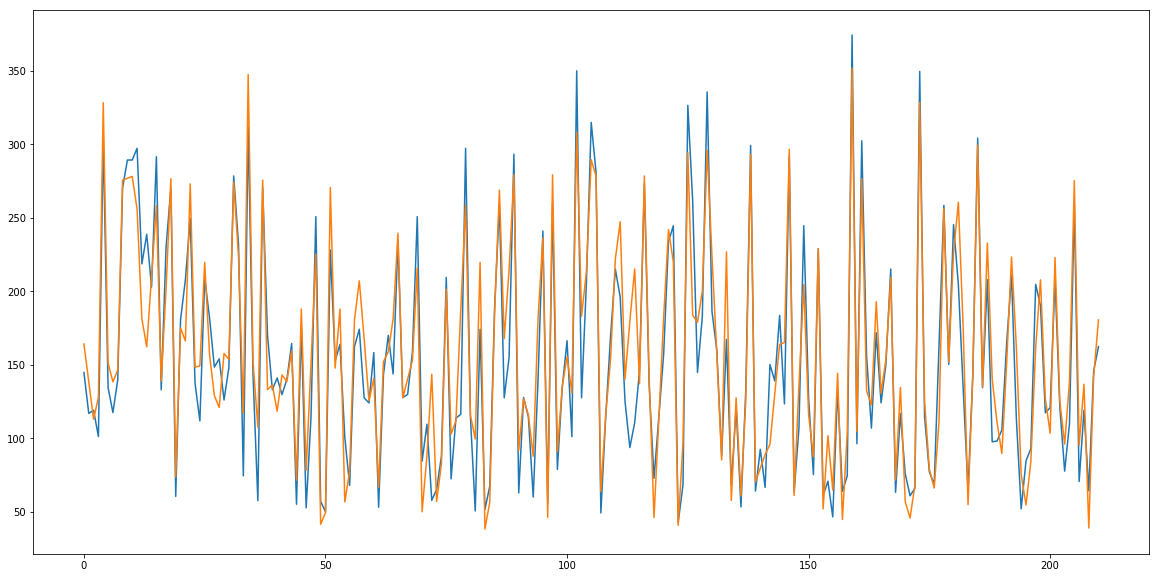

In [28]:
import matplotlib.pyplot as plt
plt.plot(y_test)
plt.plot(result)
plt.rcParams['figure.figsize']=(20,10)
plt.show()

In [13]:
result = fitted_model.predict(X_test)
sum1=0
for i in range(len(y_test)):
    diff=y_test[i]-result[i]
    if diff<0:
        diff=diff*-1
    sum1=sum1+diff
print('Avg Diff for actual ticket price and predicted ticket price',sum1/len(result))


Avg Diff for actual ticket price and predicted ticket price 14.527796887443694
